# Extracting Ion Density Profiles


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
import math
import re

resourcepath = "/home/emc/GDrive-CU/Research-Modeling/UpperAtmoDH/Resources/"

In [2]:
def quicklook_data(filename):
    # open the file containing the data extracted from some plot
    original_data = np.loadtxt(resourcepath + filename)
    
    # get species name
    species = re.search(r".+(?=-data)", filename)[0]
    print("Detected species: {}".format(species))
    
    fig = plt.figure()
    plt.scatter(original_data[:, 0], original_data[:, 1], color="gray", label=species)
    plt.legend()
    plt.xscale("log")
    plt.show()
    pass


def create_binned_profile(filename):
    
    # open the file containing the data extracted from some plot
    original_data = np.loadtxt(resourcepath + filename)
    
    # get species name
    species = re.search(r".+(?=-data)", filename)[0]
    print("Detected species: {}".format(species))

    f = si.interp1d(original_data[:, 1], original_data[:, 0], assume_sorted=False)

    data_alt_min = np.min(original_data[:, 1])
    data_alt_max = np.max(original_data[:, 1])
    print("Interpolating between min and max altitudes: [{}, {}]".format(data_alt_min, data_alt_max))
    
    
    # the floor may ask for interpolated values beyond the original data. to avoid this, add either 1 or 2 to the floor depending on parity.
    new_alt_min = math.floor(np.min(original_data[:, 1]))
    if new_alt_min % 2 == 0:
        new_alt_min += 2
    else:
        new_alt_min += 1
    # We only ever want to go up to 250 km in altitude. Leaving code here in case we need to extend later.
    new_alt_max = 252 #math.ceil(np.max(original_data[:, 1]))  
    
    print("Maximum interpolation range: [{}, {}]".format(new_alt_min, new_alt_max))

    # Create the interpolation
    species_alt = range(new_alt_min, new_alt_max, 2)
    species_n = f(species_alt)

    # Plot the interpolation
    plt.scatter(original_data[:, 0], original_data[:, 1], color="gray", label=species)
    plt.plot(species_n, species_alt, color="red")
    plt.xscale("log")
    plt.xlabel("Density (cm^-3)")
    plt.ylabel("Altitude (km)")
    plt.legend()
    plt.show()

    # Save new interpolated profile to a text file
    species_alt = np.asarray(species_alt)
    species_profile = np.column_stack((species_alt, species_n))
    species_filler = np.zeros((int(new_alt_min/2)-2, 2))  # the -2 is to make it a 124 length array instead of 126 (because densities are measured in cells, not alt grid points)
    species_filler[:, 0] = range(0, new_alt_min-4, 2)
    species_new = np.vstack((species_filler, species_profile))
    species_new_density = species_new[:, 1]
    np.savetxt(resourcepath+species+"_initial_profile.txt", species_new_density)
    pass


# HCO2+ and O2+

These profiles retrieved from Matta+ 2014.


## HCO2+

Detected species: HCO2pl


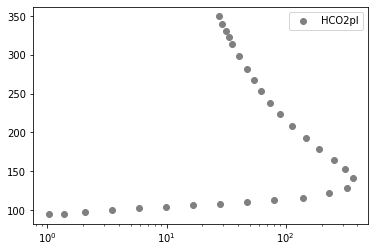

Detected species: HCO2pl
Interpolating between min and max altitudes: [94.89279937552232, 349.34695250613635]
Maximum interpolation range: [96, 252]


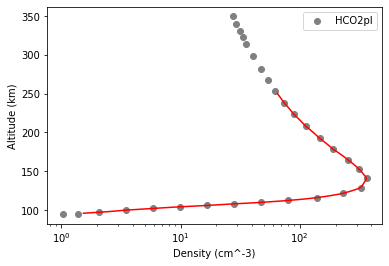

In [110]:
quicklook_data("HCO2pl-data.txt")
create_binned_profile("HCO2pl-data.txt")

## O2+

Detected species: O2pl


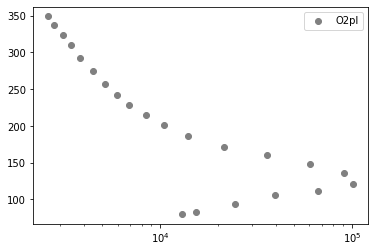

Detected species: O2pl
Interpolating between min and max altitudes: [79.95687206103582, 348.95577997695733]
Maximum interpolation range: [80, 252]


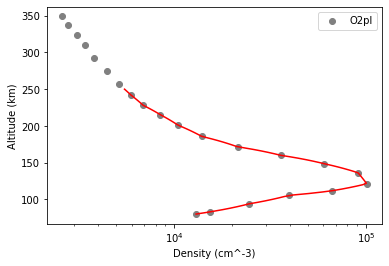

In [111]:
quicklook_data("O2pl-data.txt")
create_binned_profile("O2pl-data.txt")

# C

Retrieved from Fox and Bakalian 2001

Detected species: C


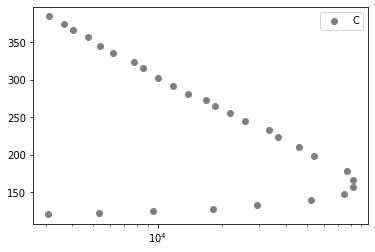

Detected species: C
Interpolating between min and max altitudes: [120.47006001740993, 384.63829202364036]
Maximum interpolation range: [122, 252]


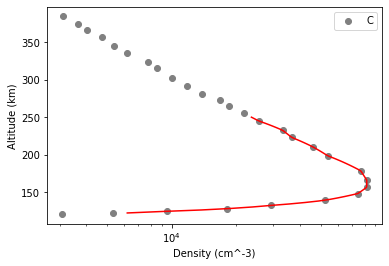

In [112]:
quicklook_data("C-data.txt")
create_binned_profile("C-data.txt")

# CO+ and CH+

Retrieved from Benna+ 2015 (NGIMS first paper)

## CO+

Detected species: COpl


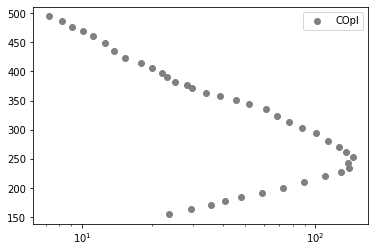

Detected species: COpl
Interpolating between min and max altitudes: [155.2343145569103, 494.16273998215684]
Maximum interpolation range: [156, 252]


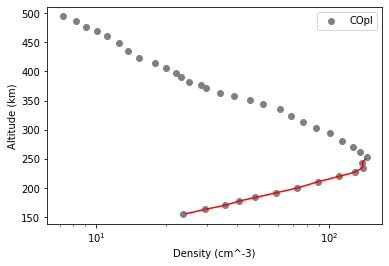

In [113]:
quicklook_data("COpl-data.txt")
create_binned_profile("COpl-data.txt")

##CH+

Detected species: CHpl


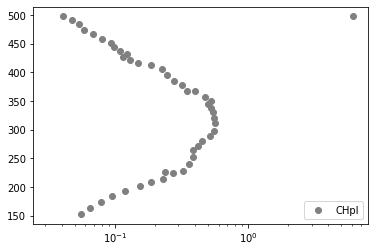

Detected species: CHpl
Interpolating between min and max altitudes: [152.85935605205378, 497.23288687153723]
Maximum interpolation range: [154, 252]


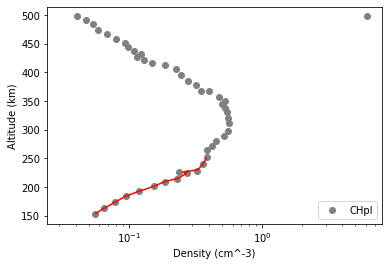

In [114]:
quicklook_data("CHpl-data.txt")
create_binned_profile("CHpl-data.txt")

## Species from Roger's model:

```
:ArHpl, :Arpl
:CH, :CN
:CNpl, :Cpl, 
:H2Opl, :H2pl, :H3Opl, :H3pl, 
:HCN, :HCNHpl, :HCNpl, :HCO, :HCOpl
:He
:HN2Opl, :HNO, :HNOpl, :HO2pl, :HOCpl
:Hpl
:N, :N2Hpl, :N2O, :N2Opl, :N2pl
:NH, :NH2, :NH2pl, :NH3pl, :NHpl
:NO, :NO2, :NO2pl, :NOpl, :Npl, 
:OHpl, :Opl
```

His altitude span goes from 80 km to 240 km.

In [9]:
# open the file I curated via command line with all of Roger's final profiles
with open("../Resources/rogers_output_odd.txt", "r") as rogersprofs_file:
    filecontents = rogersprofs_file.read().splitlines()

# tweak the species list becuase he uses different signifiers for ions
species = [i for i in filecontents[0::82]]
species = [s.replace("P", "pl") for s in species]
species = [s.replace("N2I", "N2pl") for s in species]

# generate an empty dictionary with species as keys to store their profiles
profdict = dict.fromkeys(species)

# Pull the profiles by altitude for each species. It just turns out they're 80 lines long,
# so they are regularly spaced in the file.
for s in range(1, len(species)+1):
    dictkey = species[s-1]
    start = s+(81*(s-1))
    profdict[dictkey] = np.asarray([float(i) for i in filecontents[start:start+80]])

# now construct the "padding" down to surface as 0s and the top padding from 240-250 km
# above 240, we will set the profile to be the same as the value at 238-240 km.
lowalts = np.asarray(np.arange(1e5, 81e5, 2e5))
highalts = np.asarray(np.arange(241e5, 249e5, 2e5))
zeropad = np.zeros_like(lowalts)

# Pad the altitude profile separately to construct the entire thing for my atmosphere
profdict["ALTITUDE"] = np.hstack((lowalts, profdict["ALTITUDE"], highalts))

# pad the species profiles and save them to their own file in the right directory.
for k in profdict:
#     print(k)
    if k == "ALTITUDE":
        continue
        
    # ions get a zero pad at the lower altitudes
    elif "pl" in k:
        profdict[k] = np.hstack((zeropad, profdict[k], profdict[k][-1]*np.ones_like(highalts)))
    
    # neutrals get padded with their lowest value
    else:
        print(k)
        profdict[k] = np.hstack((profdict[k][0]*np.ones_like(lowalts), profdict[k], profdict[k][-1]*np.ones_like(highalts)))
    # save it
    np.savetxt(resourcepath+"initial_profiles/"+k+"_initial_profile.txt", profdict[k])


He
N
N2D
NO
NO2
NO3
N2O
HNO
NH
NH2
C
HCO
CH
CN
HCN
E
